In [2]:
!pip install pandas numpy nltk konlpy matplotlib scikit-learn beautifulsoup4 -q

In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
import re
import imaplib
import email
from email.header import decode_header
import joblib
from settings import *
import pickle

In [16]:
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv'
data = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [18]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
def preprocess_text(text):
    text = bs(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [20]:
data['cleaned_message'] = data['message'].apply(preprocess_text)
data.head()

,label,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [21]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(data['cleaned_message'])
y = data['label'].map({'ham': 0, 'spam': 1})

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [24]:
y_pred = nb_model.predict(X_test)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9705671213208902
Precision: 1.0
Recall: 0.7795698924731183
F1 Score: 0.8761329305135952


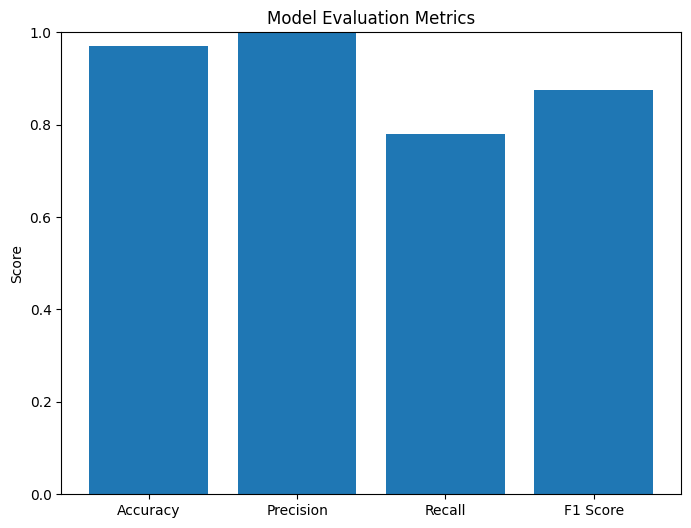

In [26]:
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 6))
plt.bar(metric_names, metrics)
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [27]:
cross_val_scores = cross_val_score(nb_model, X, y, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", np.mean(cross_val_scores))

Cross-validation scores: [0.97130045 0.96053812 0.95691203 0.96409336 0.96678636]
Mean cross-validation score: 0.9639260612989187


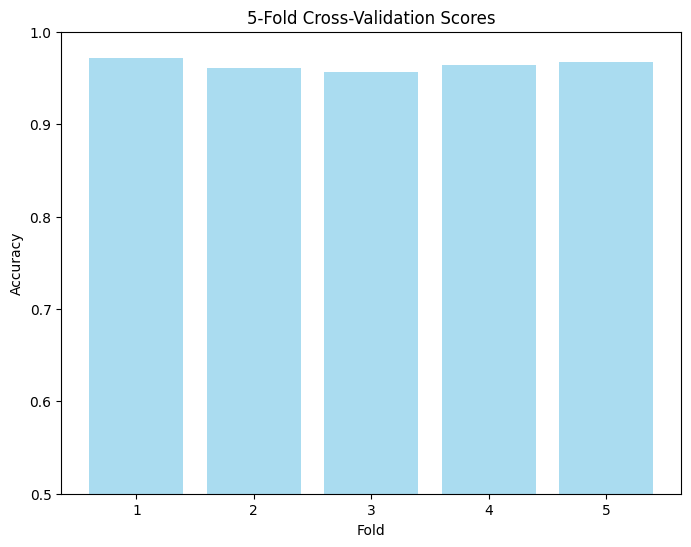

In [28]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, 6), cross_val_scores, color='skyblue', alpha=0.7)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores')
plt.xticks(range(1, 6))
plt.ylim(0.5, 1)
plt.show()

In [29]:
new_message = "Congratulations, you've won a free lottery! Claim your prize now!"
new_message_cleaned = preprocess_text(new_message)

new_message_vectorized = tfidf_vectorizer.transform([new_message_cleaned])

prediction = nb_model.predict(new_message_vectorized)

if prediction == 1:
    print("This message is Spam.")
else:
    print("This message is Ham.")

This message is Spam.


In [17]:
with open('nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)